In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient
from glob import glob
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

2023-02-05 05:37:29.713126: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-05 05:37:29.713238: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
GCS_DS_PATH = KaggleDatasets().get_gcs_path('website-defacement')

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
N_JOBS = cpu_count()

IMG_SIZE = 224
EPOCHS = 20

print('N_JOBS:', N_JOBS)
print('Batch size:', BATCH_SIZE)
print('GCS_DS_PATH:', GCS_DS_PATH)

Running on TPU: grpc://10.0.0.2:8470


2023-02-05 05:37:35.460927: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-05 05:37:35.465535: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-05 05:37:35.465576: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-05 05:37:35.465600: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5702e9043853): /proc/driver/nvidia/version does not exist
2023-02-05 05:37:35.470064: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

N_JOBS: 4
Batch size: 64
GCS_DS_PATH: gs://kds-28c0b1c93cd252058766867d437930459fd745149186a9f2adadfb8f


In [3]:
dataset_path = '../input/website-defacement/'
img_paths = glob(dataset_path + 'image/*/*')
txt_paths = glob(dataset_path + 'text/*/*')
img_names = [path.split('/')[-1][:-4] for path in img_paths]
txt_names = [path.split('/')[-1][:-4] for path in txt_paths]
names = list(set(img_names).intersection(txt_names))

In [4]:
def prepare_data(name):
    if glob(dataset_path + f'text/defaced/{name}.txt'):
        path = dataset_path + f'text/defaced/{name}.txt'
        label = 1
    else:
        path = dataset_path + f'text/benign/{name}.txt'
        label = 0
    with open(path, 'r') as f:
        text = f.read()
    return (text, label)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train_txt, X_test_txt, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)

X_train_txt, X_valid_txt, y_train, y_valid = train_test_split(X_train_txt, y_train, test_size=0.25, 
                                                      random_state=42)

  0%|          | 0/96234 [00:00<?, ?it/s]

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train_txt)

MAXLEN = 128

X_train_txt = tokenizer.texts_to_sequences(X_train_txt)
X_train_txt = pad_sequences(X_train_txt, maxlen=MAXLEN)
y_train = np.array(y_train)

X_valid_txt = tokenizer.texts_to_sequences(X_valid_txt)
X_valid_txt = pad_sequences(X_valid_txt, maxlen=MAXLEN)
y_valid = np.array(y_valid)

X_test_txt = tokenizer.texts_to_sequences(X_test_txt)
X_test_txt = pad_sequences(X_test_txt, maxlen=MAXLEN)
y_test = np.array(y_test)

In [6]:
def prepare_data(name):
    if glob(dataset_path + f'image/defaced/{name}.png'):
        return (f'{GCS_DS_PATH}/image/defaced/{name}.png', 1)
    else:
        return (f'{GCS_DS_PATH}/image/benign/{name}.png', 0)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train_img, X_test_img, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_ = to_categorical(y_train_, num_classes=2)
X_train_img, X_valid_img, y_train_, y_valid_ = train_test_split(X_train_img, y_train_, test_size=0.25, 
                                                      random_state=42)
print((y_train == y_train_).all(), (y_valid == y_valid_).all(), (y_test == y_test_).all())

  0%|          | 0/96234 [00:00<?, ?it/s]

True True True


In [7]:
def load_data(text, image_path, label=None):
    bits = tf.io.read_file(image_path)
    image = tf.image.decode_png(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
#     image = tf.reshape(image, (IMG_SIZE, IMG_SIZE, 3))
    
    data = (image, text)
    
    if label is None:
        return image, text
    else:
        return data, label

train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train_txt, X_train_img, y_train))
    .shuffle(100000)
    .map(load_data, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_test_txt, X_test_img, y_test))
    .map(load_data, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid_txt, X_valid_img, y_valid))
    .map(load_data, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

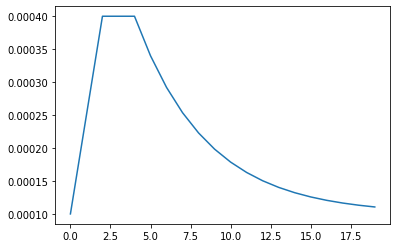

In [8]:
def lrfn(epoch=EPOCHS,
         lr_start=1e-4,
         lr_max=5e-5 * 8, 
         lr_min=1e-4,
         lr_rampup_epochs=2,
         lr_sustain_epochs=2,
         lr_exp_decay=0.8):
    if epoch < lr_rampup_epochs:
        lr = (lr_max-lr_start)/lr_rampup_epochs*epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max-lr_min)*lr_exp_decay**(epoch-lr_rampup_epochs-lr_sustain_epochs) + lr_min
    return lr

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

### ViTB32

353255424/353253686 [==============================] - 4s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


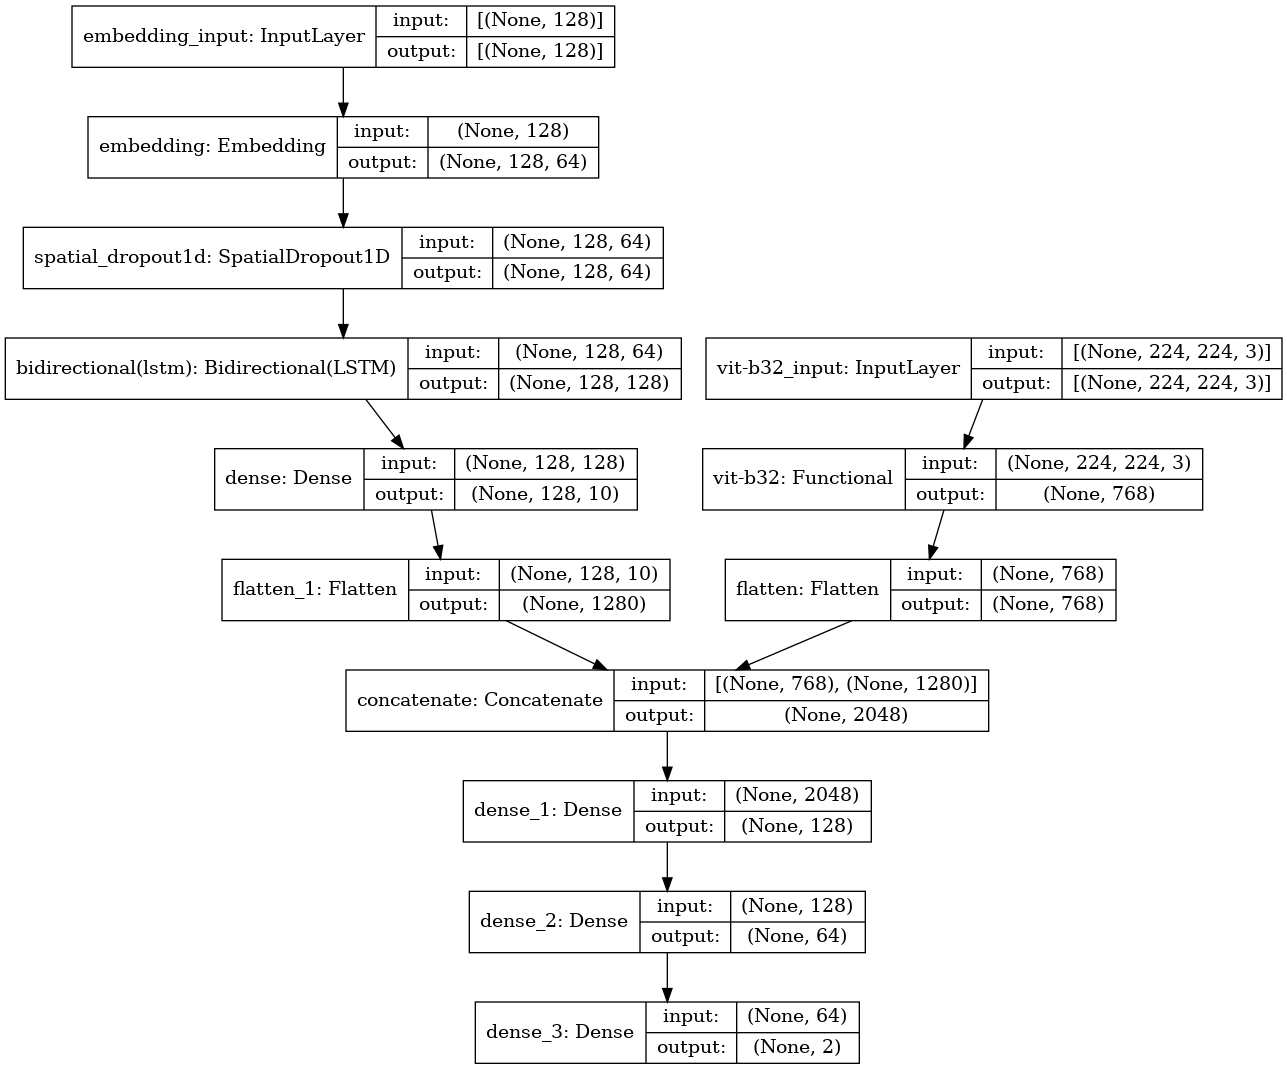

In [9]:
!pip install --quiet vit-keras

from vit_keras import vit
with strategy.scope():
    image_model = Sequential()
    net = vit.vit_b32(
        image_size = (IMG_SIZE, IMG_SIZE),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False
    )
    image_model.add(net)
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Bidirectional(L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [10]:
    lrs = LearningRateScheduler(lrfn)  
    # tf.config.run_functions_eagerly(True)
    mc = ModelCheckpoint('vit_weights.h5', save_best_only=True, save_weights_only=True)
    steps_per_epoch = len(y_train) // BATCH_SIZE

    hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                     callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171364928 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 2326s - loss: 0.1629 - accuracy: 0.9350 - val_loss: 0.0836 - val_accuracy: 0.9717
Epoch 2/20
902/902 - 88s - loss: 0.0284 - accuracy: 0.9907 - val_loss: 0.1086 - val_accuracy: 0.9717
Epoch 3/20
902/902 - 88s - loss: 0.0085 - accuracy: 0.9978 - val_loss: 0.1163 - val_accuracy: 0.9715
Epoch 4/20
902/902 - 88s - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.1263 - val_accuracy: 0.9707
Epoch 5/20
902/902 - 88s - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.2002 - val_accuracy: 0.9665
Epoch 6/20
902/902 - 88s - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.1449 - val_accuracy: 0.9705
Epoch 7/20
902/902 - 87s - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.2063 - val_accuracy: 0.9524
Epoch 8/20
902/902 - 88s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1699 - val_accuracy: 0.9699
Epoch 9/20
902/902 - 88s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.2153 - val_accuracy: 0.9523
Epoch 10/20
902/902 - 88s - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.1882 - val_accuracy: 0.969

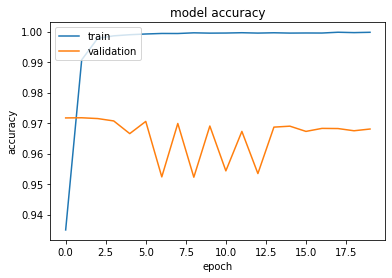

In [11]:
plot_hist(hist)

In [12]:
with strategy.scope():
    model.load_weights('vit_weights.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 541s 2s/step
              precision    recall  f1-score   support

           0     0.9643    0.9853    0.9747     11412
           1     0.9779    0.9469    0.9621      7835

    accuracy                         0.9697     19247
   macro avg     0.9711    0.9661    0.9684     19247
weighted avg     0.9698    0.9697    0.9696     19247

[[11244   168]
 [  416  7419]]
      TPR       FPR       FNR   ROC AUC
   0.9469    0.0147    0.0531    0.9948


### VGG19

80142336/80134624 [==============================] - 0s 0us/step


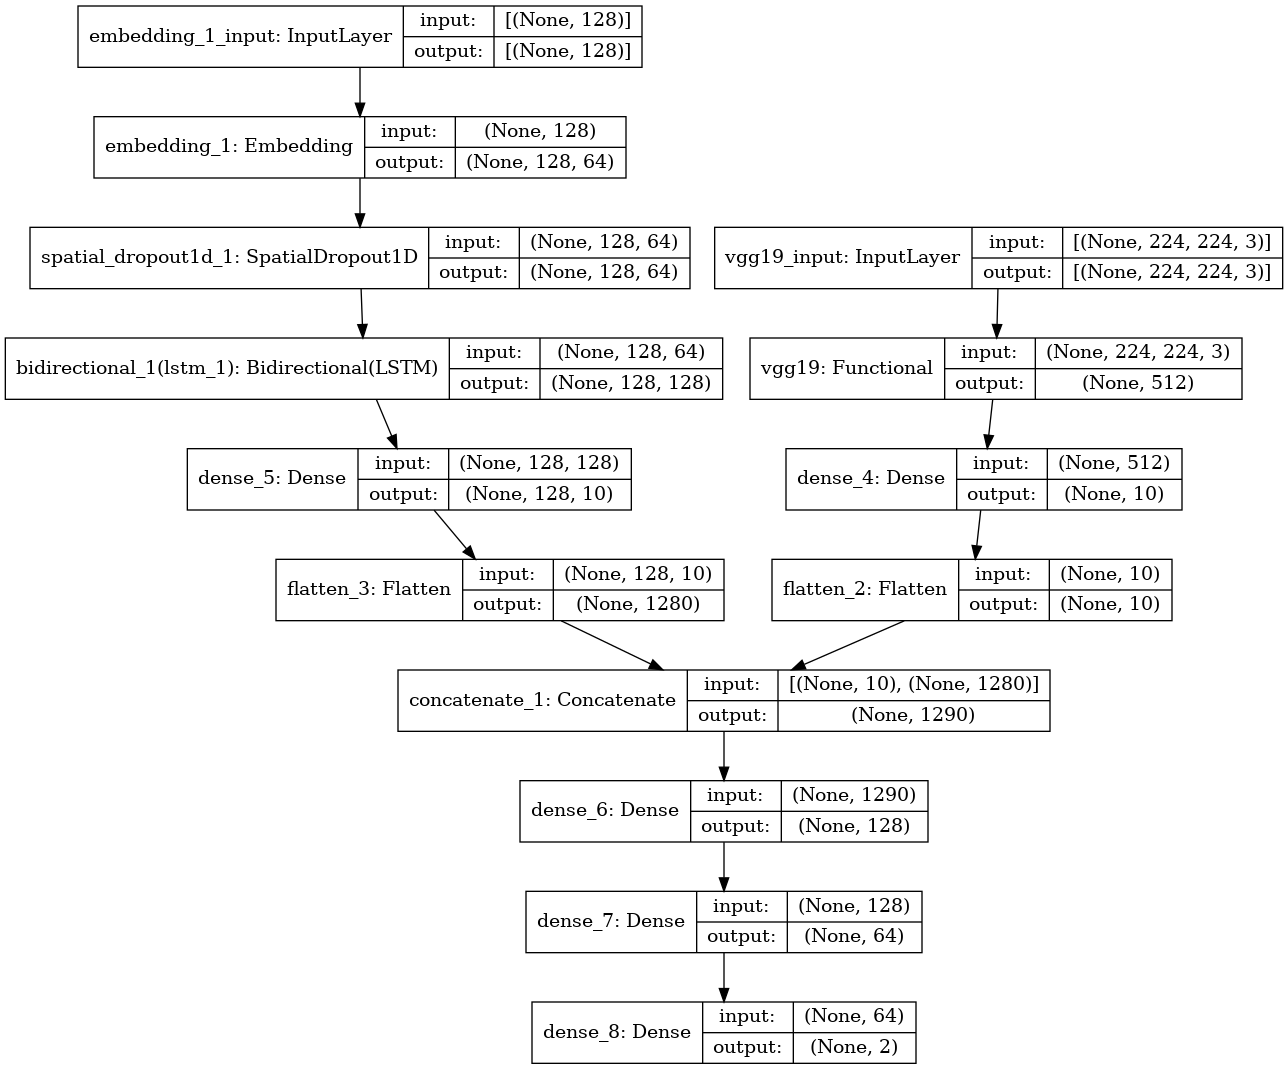

In [13]:
from tensorflow.keras.applications import VGG19
with strategy.scope():
    image_model = Sequential()
    net = VGG19(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    image_model.add(net)
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Bidirectional(L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [14]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('vgg_weights.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171364928 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 120s - loss: 0.1617 - accuracy: 0.9329 - val_loss: 0.0910 - val_accuracy: 0.9690
Epoch 2/20
902/902 - 82s - loss: 0.0248 - accuracy: 0.9919 - val_loss: 0.1110 - val_accuracy: 0.9699
Epoch 3/20
902/902 - 82s - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.1198 - val_accuracy: 0.9689
Epoch 4/20
902/902 - 82s - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.1395 - val_accuracy: 0.9672
Epoch 5/20
902/902 - 82s - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.1410 - val_accuracy: 0.9663
Epoch 6/20
902/902 - 82s - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.1424 - val_accuracy: 0.9695
Epoch 7/20
902/902 - 82s - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.1741 - val_accuracy: 0.9657
Epoch 8/20
902/902 - 82s - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.1768 - val_accuracy: 0.9659
Epoch 9/20
902/902 - 82s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.1860 - val_accuracy: 0.9668
Epoch 10/20
902/902 - 82s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.2025 - val_accuracy: 0.9676

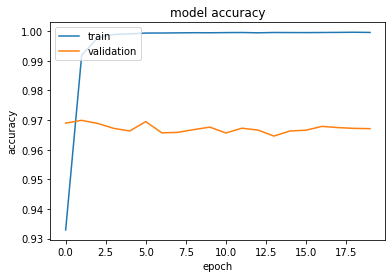

In [15]:
plot_hist(hist)

In [16]:
with strategy.scope():
    model.load_weights('vgg_weights.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 429s 1s/step
              precision    recall  f1-score   support

           0     0.9589    0.9869    0.9727     11412
           1     0.9800    0.9384    0.9587      7835

    accuracy                         0.9671     19247
   macro avg     0.9694    0.9626    0.9657     19247
weighted avg     0.9675    0.9671    0.9670     19247

[[11262   150]
 [  483  7352]]
      TPR       FPR       FNR   ROC AUC
   0.9384    0.0131    0.0616    0.9943


### DenseNet169

51879936/51877672 [==============================] - 0s 0us/step


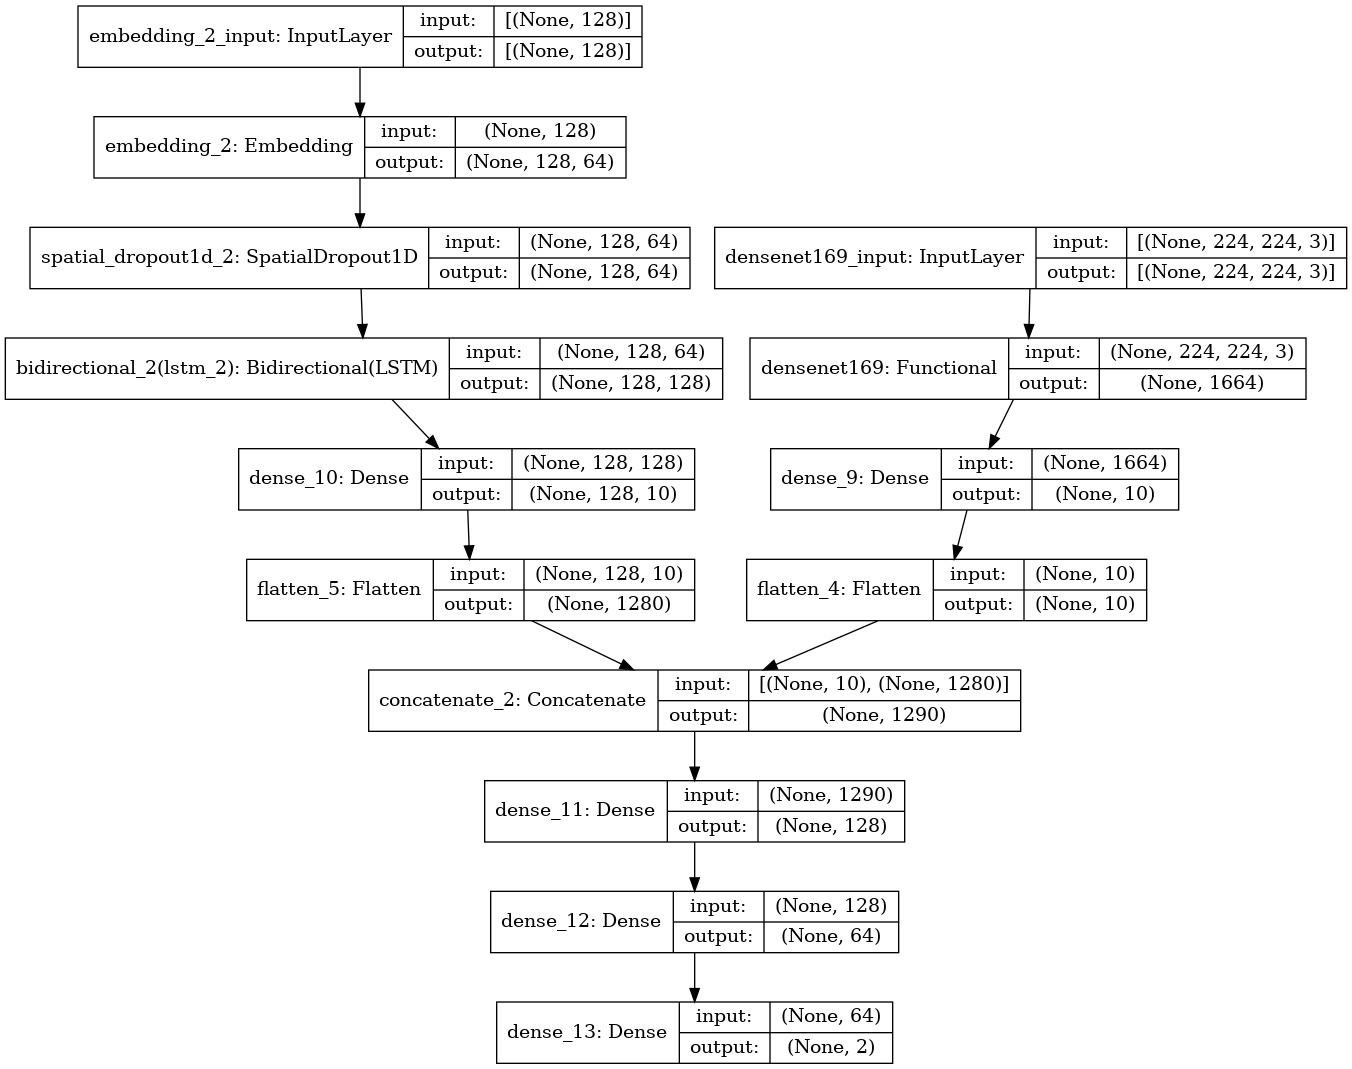

In [17]:
from tensorflow.keras.applications import DenseNet169
with strategy.scope():
    image_model = Sequential()
    net = DenseNet169(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    image_model.add(net)
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Bidirectional(L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [18]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('dense_weights.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171364928 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 266s - loss: 0.1451 - accuracy: 0.9437 - val_loss: 0.1102 - val_accuracy: 0.9693
Epoch 2/20
902/902 - 121s - loss: 0.0238 - accuracy: 0.9922 - val_loss: 0.1004 - val_accuracy: 0.9718
Epoch 3/20
902/902 - 121s - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.1205 - val_accuracy: 0.9715
Epoch 4/20
902/902 - 121s - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.1296 - val_accuracy: 0.9704
Epoch 5/20
902/902 - 120s - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.1412 - val_accuracy: 0.9693
Epoch 6/20
902/902 - 121s - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.1743 - val_accuracy: 0.9638
Epoch 7/20
902/902 - 120s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1854 - val_accuracy: 0.9667
Epoch 8/20
902/902 - 120s - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.1645 - val_accuracy: 0.9677
Epoch 9/20
902/902 - 121s - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.1454 - val_accuracy: 0.9700
Epoch 10/20
902/902 - 121s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1852 - val_accurac

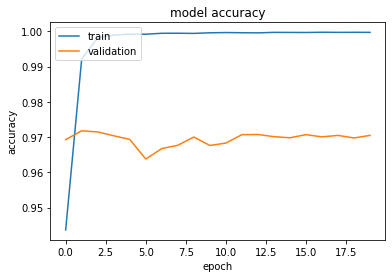

In [19]:
plot_hist(hist)

In [20]:
with strategy.scope():
    model.load_weights('dense_weights.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 455s 2s/step
              precision    recall  f1-score   support

           0     0.9701    0.9822    0.9761     11412
           1     0.9736    0.9558    0.9646      7835

    accuracy                         0.9715     19247
   macro avg     0.9718    0.9690    0.9704     19247
weighted avg     0.9715    0.9715    0.9714     19247

[[11209   203]
 [  346  7489]]
      TPR       FPR       FNR   ROC AUC
   0.9558    0.0178    0.0442    0.9951
